In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, get_sun
from astropy.coordinates import Angle
from astropy import units as u
from alerts import get_alerts, make_alerts
from datetime import datetime, date
from style import output_folder, big_fontsize, base_width, base_height, dpi, CB_color_cycle
import seaborn as sns
import json
from astropy.time import Time

In [2]:
make_alerts()

IC190922B: Two matching dates.
	148.09 degrees apart
	assuming it's two alerts at the same day
IC200107A: No notice becasue selected offline
IC200926A: Two matching dates.
	94.11 degrees apart
	assuming it's two alerts at the same day
IC160427A: selecting the third notice of 4
IC160731A: Two matching dates.
	0.56 degrees apart
	assuming second notice is refined info from circular. choosing first one
IC161103A: Two matching dates.
	0.07 degrees apart
	assuming second notice is refined info from circular. choosing first one
IC161210A: Two matching dates.
	1.07 degrees apart
	assuming it's two alerts at the same day
IC190922A: Two matching dates.
	148.09 degrees apart
	assuming it's two alerts at the same day
IC200926B: Two matching dates.
	94.11 degrees apart
	assuming it's two alerts at the same day
IC201115A: Two matching dates.
	49.55 degrees apart
	assuming it's two alerts at the same day
IC201115B: Two matching dates.
	49.55 degrees apart
	assuming it's two alerts at the same day
IC

In [2]:
alerts = get_alerts()

In [ ]:
alerts

In [5]:
alerts[~alerts.retracted & alerts['2h coverage'].isna()]

,Event,Class,RA,RA Unc (rectangle),Dec,Dec Unc (rectangle),arrival time [UT],Signalness,initial RA,initial Dec,...,3d coverage,4d coverage,5d coverage,6d coverage,7d coverage,14d coverage,observed,controll_Event,Before,After
46,IC190504A,HESE,65.7866,NaN,-37.4431,NaN,2019-05-04 18:25:18.39,NaN,65.7866,-37.4431,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
59,IC200227A,BRONZE,348.2600,NaN,21.3200,NaN,2020-02-27 05:36:31.49,0.35075,348.2598,21.3235,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN


85 alerts in total
12 alerts retracted
56 observed by ASAS-SN
15 not observed
15 observed within 2 hours
41 observed within 14 days
2 alerts missing direction uncertainties


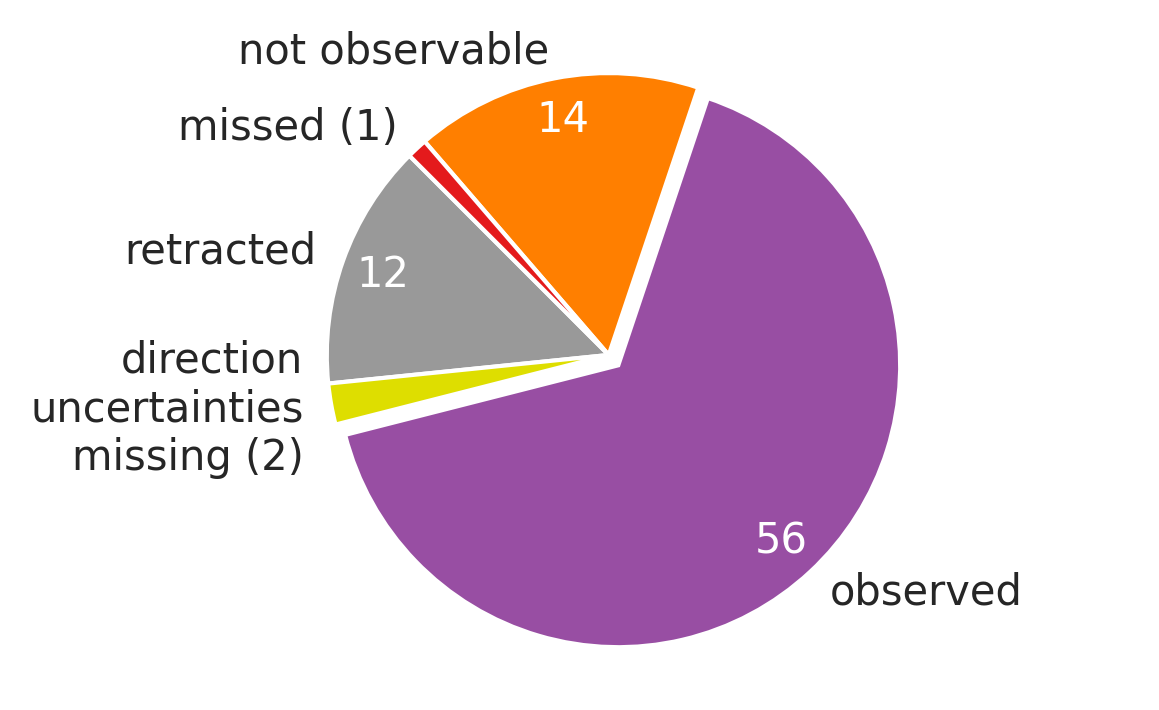

In [119]:

Nalerts = len(alerts.Event.unique())
N_retracted = len(alerts[alerts.retracted].Event.unique())
Nalerts_observed = len(alerts[alerts.observed].Event.unique())
Nalerts_unobserved = len(alerts[~alerts.observed & ~alerts.retracted & ~alerts["direction uncertainty missing"]].Event.unique())
N_observed_2h = len(alerts[alerts["2h coverage"]>0].Event.unique())
N_dir_missing = len(alerts[alerts["direction uncertainty missing"]])
N_not_observable = 14
N_observable_not_observed = 1

print(
    f"{Nalerts} alerts in total\n" \
    f"{N_retracted} alerts retracted\n" \
    f"{Nalerts_observed} observed by ASAS-SN\n" \
    f"{Nalerts_unobserved} not observed\n" \
    f"{N_observed_2h} observed within 2 hours\n" \
    f"{Nalerts_observed-N_observed_2h} observed within 14 days\n" \
    f"{N_dir_missing} alerts missing direction uncertainties"
)

labels = ['retracted', 'direction\nuncertainties\nmissing', 'observed', 'not observable', 'missed']
sizes = [N_retracted, N_dir_missing, Nalerts_observed, N_not_observable, N_observable_not_observed]
explode = [0, 0, 0.05, 0, 0]
labels_with_numbers = [f"{l} ({n})" if n < 3 else l for l, n in zip(labels, sizes)]

assert len(labels) == len(sizes)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
#         return '{p:.0f}%\n({v:d})'.format(p=pct,v=val)
        return f"{val:.0f}" if val > 3 else ""
    return my_autopct


fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
_, _, autotxts = ax.pie(sizes, labels=labels_with_numbers, autopct=make_autopct(sizes),
        shadow=False, startangle=135,
       pctdistance=0.85,
       textprops={'fontsize': big_fontsize},
      colors=np.array(CB_color_cycle)[[6, 8, 5, 1, 7]],
      explode=explode)

for autotext in autotxts:
    autotext.set_color('white')
ax.axis('equal')
fig.tight_layout()
fig.savefig("../figures/alert_stats_piechart.pdf")
plt.show()
plt.close()

85 alerts in total
12 alerts retracted
56 observed by ASAS-SN
15 not observed
15 observed within 2 hours
41 observed within 14 days
2 alerts missing direction uncertainties


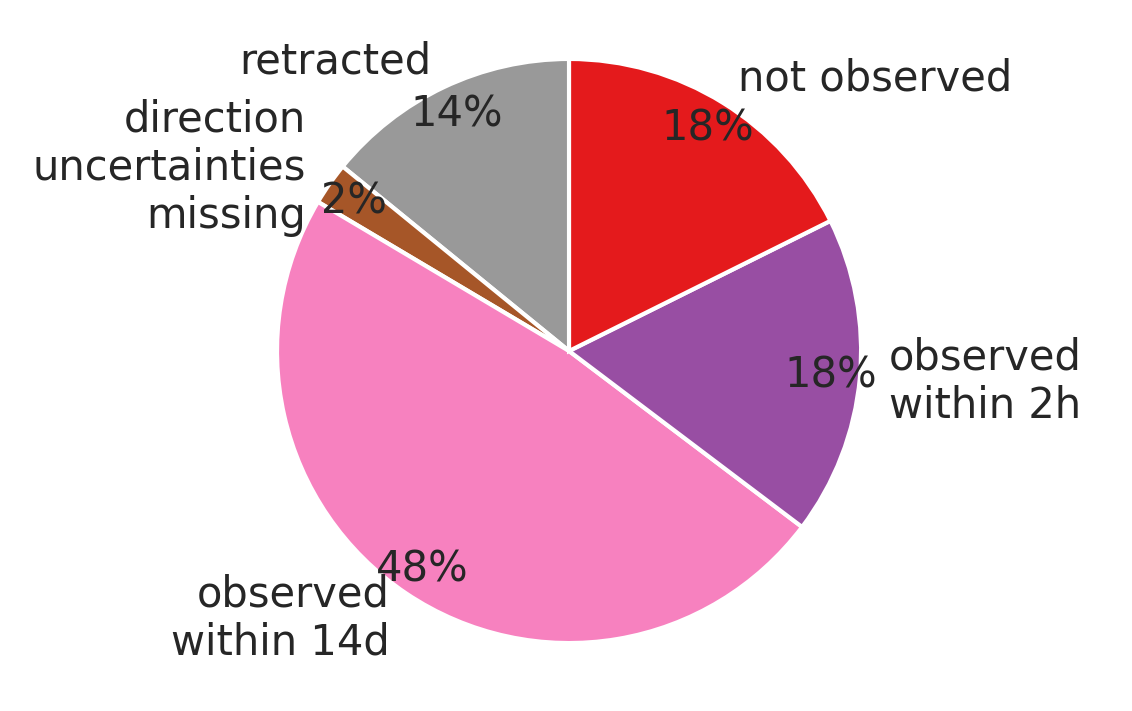

In [7]:

Nalerts = len(alerts.Event.unique())
N_retracted = len(alerts[alerts.retracted].Event.unique())
Nalerts_observed = len(alerts[alerts.observed].Event.unique())
Nalerts_unobserved = len(alerts[~alerts.observed & ~alerts.retracted & ~alerts["direction uncertainty missing"]].Event.unique())
N_observed_2h = len(alerts[alerts["2h coverage"]>0].Event.unique())
N_dir_missing = len(alerts[alerts["direction uncertainty missing"]])

print(
    f"{Nalerts} alerts in total\n" \
    f"{N_retracted} alerts retracted\n" \
    f"{Nalerts_observed} observed by ASAS-SN\n" \
    f"{Nalerts_unobserved} not observed\n" \
    f"{N_observed_2h} observed within 2 hours\n" \
    f"{Nalerts_observed-N_observed_2h} observed within 14 days\n" \
    f"{N_dir_missing} alerts missing direction uncertainties"
)

labels = ['retracted', 'direction\nuncertainties\nmissing', 'observed\nwithin 14d', 'observed\nwithin 2h', 'not observed']
sizes = [N_retracted, N_dir_missing, Nalerts_observed-N_observed_2h, N_observed_2h, Nalerts_unobserved]
explode = [0, 0, 0, 0, 0]

assert len(labels) == len(sizes)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
#         return '{p:.0f}%\n({v:d})'.format(p=pct,v=val)
        return f"{val/total *100:.0f}%"
    return my_autopct


fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
ax.pie(sizes, labels=labels, autopct=make_autopct(sizes),
        shadow=False, startangle=90,
       pctdistance=0.9,
       textprops={'fontsize': big_fontsize},
      colors=np.array(CB_color_cycle)[[6, 4, 3, 5, 7]],
      explode=explode)
ax.axis('equal')
fig.tight_layout()
fig.savefig("../figures/alert_stats_piechart_relative.pdf")
plt.show()
plt.close()

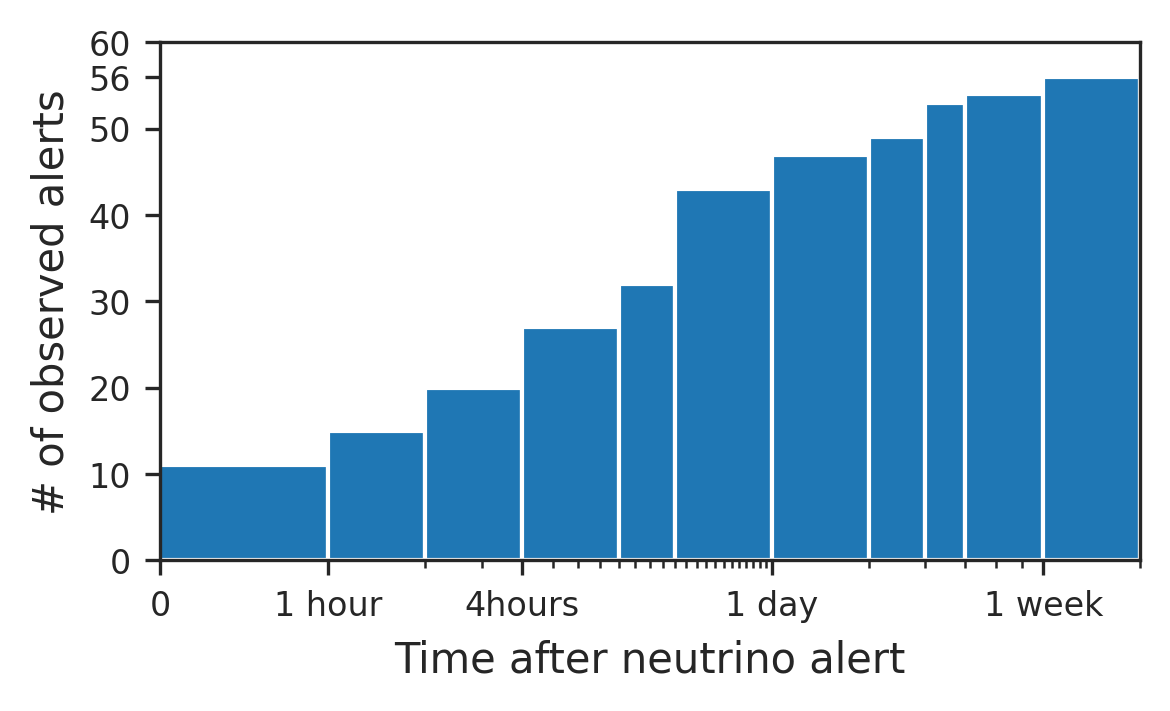

In [8]:
dupe = alerts.Event.duplicated()


coverge_columns = [c for c in alerts.columns if 'coverage' in c]
coverage_values = list()
for c in coverge_columns:
    vv = c.strip(' coverage')
    val = float(vv[:-1])
    unit = u.Unit(vv[-1])
    coverage_values.append(val*unit)

alerts['covered after h'] = np.inf
    
for i, r in alerts.iterrows():
    covs = r[coverge_columns]
    w = np.where(covs > 0)[0]
    if len(w) > 0:
        if min(w) > 0:
            val = coverage_values[min(w)-1].to('h').value
        else:
            val = 0
        alerts.loc[i, 'covered after h'] = val
    
selcov = coverage_values[:9] + coverage_values[-2:]
bins = [0] + [c.to('h').value for c in selcov] + [2*7*24]
    
fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
h = ax.hist(alerts['covered after h'][alerts.observed & ~dupe], bins=bins, cumulative=True)
ax.set_xscale('log')

minor_ticks =  list(range(1, 24)) + list(np.array(range(1, 7)) * 24) + list(np.array(range(1, 3))*24*7)
xticks = [0.3, 1, 4, 24, 168]
xticklabels = ['0', '1 hour', '4hours', '1 day', '1 week']

yticks = ax.get_yticks()
yticks = list(yticks) + [sum(alerts.observed[~dupe])]
ax.set_yticks(yticks)


ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['']*len(minor_ticks), minor=True)
ax.set_xlabel('Time after neutrino alert')
ax.set_ylabel('# of observed alerts')

#ax2 = ax.twinx()
#ax2.hist(alerts['covered after h'][alerts.observed & ~dupe], bins=bins, cumulative=True, density=True)
#ps = np.array([0, 0.25, 0.5, 0.75, 1])
#ax2.set_yticks(ps)
#ax2.set_yticklabels((ps*100).astype(int))
#ax2.set_ylabel('Percentage of alerts')
#ax2.grid()
ax.set_xlim((0.3, max(minor_ticks)))
fig.tight_layout()
# fig.savefig('../figures/time_of_observation.pdf')
plt.show()

In [94]:
times = Time(list(alerts["arrival time [UT]"]))
five_st_time = Time("2019-06-01")
alerts["five_stations"] = times > five_st_time

two_st_yr = (five_st_time - min(times)).to("yr").value
total_yr = (max(times) - min(times)).to("yr").value
five_st_yr = total_yr - two_st_yr

two_st_alerts = len(times[(times < five_st_time) & ~alerts.Event.duplicated()])
five_st_alerts = len(times[(times > five_st_time) & ~alerts.Event.duplicated()])
total_alerts = len(alerts[~alerts.Event.duplicated()])

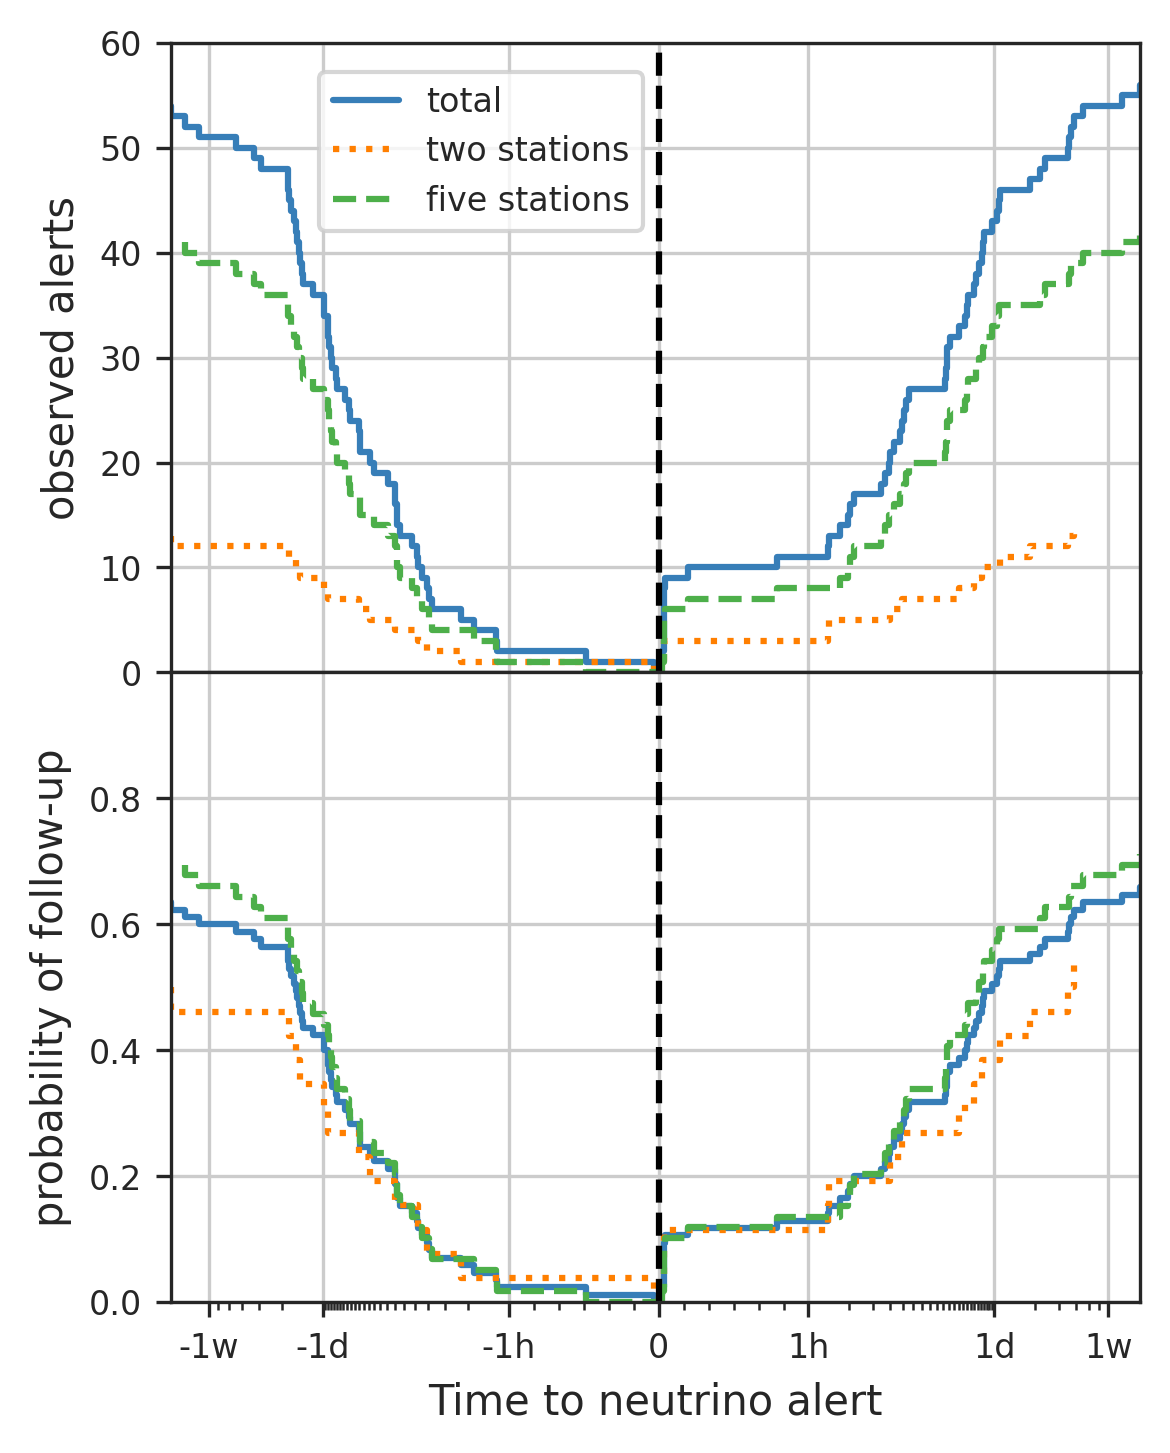

In [104]:
fig, (ax, ratioax) = plt.subplots(nrows=2, figsize=(base_width, 2*base_height), dpi=dpi,
                      gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]}, sharex='col')
fig.subplots_adjust(wspace=0.)

unmasked = [True] * len(alerts)

for m, c, ls, l, normto in zip(
    [unmasked, ~alerts.five_stations, alerts.five_stations],
    [CB_color_cycle[0], CB_color_cycle[1], CB_color_cycle[2]],
    ["-", ":", "--"],
    ["total", "two stations", "five stations"],
    [total_alerts, two_st_alerts, five_st_alerts]
):

    mbefore = (~alerts.Before.isna()) & ~alerts.Event.duplicated() & m
    sorted_before = alerts[mbefore].sort_values(by="Before", ignore_index=True, ascending=True)

    mafter = (~alerts.After.isna()) & ~alerts.Event.duplicated() & m
    sorted_after = alerts[mafter].sort_values(by="After", ignore_index=True)

    times_before = list(-sorted_before.Before[::-1]) + [0]
    times_after = [0] + list(sorted_after.After)
    N_before = list(sorted_before.index[::-1] + 1) + [0]
    N_after = [0] + list(sorted_after.index+1)

    ax.plot(times_before, N_before, drawstyle='steps-pre', color=c, ls=ls, label=l) 
    ax.plot(times_after, N_after, drawstyle='steps-post', color=c, ls=ls)
    
    ratioax.plot(times_before, np.array(N_before) / normto, drawstyle='steps-pre', color=c, ls=ls)
    ratioax.plot(times_after, np.array(N_after)/normto, drawstyle='steps-post', color=c, ls=ls)
    
ax.set_xscale("symlog", linthresh=1)

for a in [ax, ratioax]:
    a.axvline(0, ls='--', color='k')
    a.grid()

# minor_ticks =  np.array(list(np.linspace(10, 50, 5)/3600) + list(np.linspace(1, 59, 59)/60) + list(range(1, 24)) + list(np.array(range(1, 7)) * 24) + list(np.array(range(1, 3))*24*7))
minor_ticks =  np.array(list(np.linspace(10, 50, 5)/60) + list(range(1, 24)) + list(np.array(range(1, 7)) * 24) + list(np.array(range(1, 3))*24*7))
xticks = [1, 24, 168]
xticklabels = ['1h', '1d', '1w']

ax.set_xticks(list(-np.array(xticks)) + [0] + xticks)
ax.set_xticklabels(["-" + xtl for xtl in xticklabels] + [0] + ["" + xtl for xtl in xticklabels])
ax.set_xticks(list(-minor_ticks) + list(minor_ticks), minor=True)
ax.set_xticklabels(['']*len(minor_ticks)*2, minor=True)

ax.set_ylim([0, 60])
ratioax.set_ylim([0, 1])
ratioax.set_yticks(np.linspace(0, 0.8, 5))
ax.set_xlim([min(-alerts.Before), max(alerts.After)])

ratioax.set_xlabel('Time to neutrino alert')
ax.set_ylabel('observed alerts')
ratioax.set_ylabel("probability of follow-up")
ax.legend(bbox_to_anchor = (0.32,0.98), ncol=1, loc='upper center')

fig.tight_layout()
fig.savefig("../figures/time_of_observation.pdf")

plt.show()

In [30]:
for k in ["After", "Before"]:
    print(k)
    for dt in [5/60, 1, 2, 24, 7*24, 14*24]:
        N = sum(alerts[k][alerts.observed & ~alerts.Event.duplicated()] < dt)
        print(dt, N)
        

After
0.08333333333333333 9
1 11
2 15
24 43
168 54
336 56
Before
0.08333333333333333 1
1 2
2 5
24 36
168 50
336 52


In [46]:
sel = alerts[(alerts.Before < 1) & alerts.observed][["Event", "Before", "After"]]
sel.Before *= 60
sel.After *= 3600
sel

,Event,Before,After
27,IC161103A,1.758333,2.5
9,IC200530A,29.213333,144.5


In [78]:
m = alerts.observed & ~alerts.Event.duplicated()
for mm in [alerts.five_stations, ~alerts.five_stations]:
    fst = alerts[mm & m]
    N_1day = sum(fst.After < 24)
    print(len(fst), N_1day, N_1day/len(fst))

42 33 0.7857142857142857
14 10 0.7142857142857143


In [99]:
0.2/0.6


0.33333333333333337

In [24]:
alerts[m]

,Event,Class,RA,RA Unc (rectangle),Dec,Dec Unc (rectangle),arrival time [UT],Signalness,initial RA,initial Dec,...,4d coverage,5d coverage,6d coverage,7d coverage,14d coverage,observed,controll_Event,Before,After,five_stations


In [9]:
alerts[["Event", "Before", "After"]][alerts.After < 5/60]

,Event,Before,After
27,IC161103A,0.029306,0.000694
44,IC190221A,23.665300,0.035417
0,IC190503A,35.432560,0.032000
9,IC200530A,0.486889,0.040139
68,IC200911A,3.745510,0.032583
72,IC201114A,7.967810,0.034278
16,IC201130A,15.161630,0.022222
19,IC210210A,3.926710,0.036417
22,IC210811A,7.047400,0.035472


In [12]:
0.03 * 60

1.7999999999999998

In [10]:
obs = pd.read_csv("data/nu_alerts_observed.csv", skiprows=[0, 1, 2])


obs = obs[~np.isnan(obs["RA"])]

non = pd.read_csv("data/nu_alerts_unobserved.csv", skiprows=[0, 1], usecols=range(11))

# Observed alerts (Table 1)

In [175]:
m = list()
for i, r in alerts.iterrows():
    try:
        ras = r["RA Unc (rectangle) float"]
        decs = r["Dec Unc (rectangle) float"]   
        delta_r = ras[0] - ras[1]
    except TypeError:
        m.append(i)
alerts.loc[m]

,Event,Class,RA,RA Unc (rectangle),Dec,Dec Unc (rectangle),arrival time [UT],Signalness,initial RA,initial Dec,initial Error90 [arcmin],retracted,RA Unc (rectangle) float,Dec Unc (rectangle) float,2h coverage,14d coverage,observed
34,IC171028A,HESE,NaN,NaN,NaN,NaN,2017-10-28 08:28:14.81,0.226141,275.0760,34.5011,534.00,True,None,None,NaN,NaN,False
36,IC180423A,HESE,NaN,NaN,NaN,NaN,2018-04-23 02:28:40.98,0.477273,294.8820,71.9530,534.00,True,None,None,NaN,NaN,False
40,IC181031A,HESE,NaN,NaN,NaN,NaN,2018-10-31 02:02:51.41,0.477273,182.7920,-68.3884,73.79,True,None,None,NaN,NaN,False
43,IC190205A,HESE,NaN,NaN,NaN,NaN,2019-02-05 21:21:10.50,0.262467,128.6959,-53.3143,73.79,True,None,None,NaN,NaN,False
46,IC190504A,HESE,65.7866,NaN,-37.4431,NaN,2019-05-04 18:25:18.39,0.439614,65.7866,-37.4431,73.79,False,None,None,NaN,NaN,False
47,IC190529A,HESE,NaN,NaN,NaN,NaN,2019-05-29 01:55:22.21,0.477273,287.3190,78.1432,534.00,True,None,None,NaN,NaN,False
48,IC190629A,BRONZE,27.2200,NaN,84.3300,"[4.95, -3.13]",2019-06-29 19:24:15.12,0.338920,25.6392,84.5382,114.81,False,None,"[4.95, -3.13]",0.0,70.6,True
58,IC200120A,BRONZE,NaN,NaN,NaN,NaN,2020-01-20 18:48:18.55,NaN,67.7381,-14.5870,30.80,True,None,None,NaN,NaN,False
59,IC200227A,BRONZE,348.2600,NaN,21.3200,NaN,2020-02-27 05:36:31.49,0.350750,348.2598,21.3235,30.80,False,None,None,NaN,NaN,False
66,IC200728A,GOLD,NaN,NaN,NaN,NaN,2020-07-28 08:17:51.99,NaN,117.5554,-24.8475,30.80,True,None,None,NaN,NaN,False


In [124]:
m = alerts['observed'] & (~alerts.retracted)


text = ""


tot_area = 0.

for index, row in alerts[m].iterrows():
    
    if (row.Event == 'IC160731A') & (row.Class == 'HESE'):
        continue
        
    
    name = str(row["Event"].lower())
    ras = row["RA Unc (rectangle) float"]
    decs = row["Dec Unc (rectangle) float"]   

    if row['Event'] in ['IC190504A', 'IC200227A']:
        area = row['initial Error90 [arcmin]']**2 *4*np.pi
    try:
        if row['Event'] == 'IC190629A':
            delta_r = 2*np.pi
        
        else:
            delta_r = ras[0] - ras[1]
        delta_d = decs[0] - decs[1]

        area = delta_r * delta_d  * np.cos(np.radians(float(row["Dec"])))
    except TypeError:
        print(row, '\n')
        area = np.nan
        
    if not np.isnan(area):
        tot_area += area * row["14d coverage"]/100

    if np.isnan(float(row["Signalness"])):
        s = "-"
    else:
        s = f'{100.*row["Signalness"]:.0f}'
        
    # if row.Class == 'HESE':
    #     s += "$^{*}$"
    if row.Class == 'EXTRA':
        s += "$^{*}$"
        
    ref = '-' if row.Event == "IC160731A" else f"\cite{{{name}}}"

    text += f'{row["Event"]} & {row["RA"]:.2f} & ${row["Dec"]:+.2f}$ & {area:.1f} & {row["24h coverage"]:.1f} & {row["14d coverage"]:.1f} & {s} & {ref} \\\ \n'.replace("-", "-")

    #text += f'\t &&&&&& \cite{{{name}_ztf}} \\\\ \n'
    #if not isinstance(row["Additional ZTF GCN"], float):
    #    text += f'\t &&&&&& \cite{{{name}_ztf_2}} \\\\ \n'

    #tot_area += row["Observed area (corrected for chip gaps)"]

print(text)

with open(f'../latex/alert_table_observed.tex', 'w') as f:
    f.write(text)
    
print(tot_area)

IC160427A & 240.57 & $+9.34$ & 1.4 & 100.0 & 100.0 & - & \cite{ic160427a} \\ 
IC160731A & 214.50 & $-0.33$ & 2.2 & 36.2 & 100.0 & 85 & - \\ 
IC160814A & 200.30 & $-32.40$ & 12.0 & 0.0 & 100.0 & - & \cite{ic160814a} \\ 
IC161103A & 40.83 & $+12.56$ & 3.1 & 79.9 & 100.0 & - & \cite{ic161103a} \\ 
IC161210A & 46.58 & $+14.98$ & 1.7 & 0.0 & 100.0 & 49 & \cite{ic161210a} \\ 
IC170312A & 305.15 & $-26.61$ & 0.9 & 0.0 & 100.0 & - & \cite{ic170312a} \\ 
IC170321A & 98.30 & $-15.02$ & 5.6 & 4.5 & 100.0 & 28 & \cite{ic170321a} \\ 
IC170922A & 77.43 & $+5.72$ & 1.3 & 100.0 & 100.0 & 57 & \cite{ic170922a} \\ 
IC171106A & 340.00 & $+7.40$ & 0.7 & 100.0 & 100.0 & 75 & \cite{ic171106a} \\ 
IC181023A & 270.18 & $-8.57$ & 9.3 & 70.5 & 100.0 & 28 & \cite{ic181023a} \\ 
IC190104A & 357.98 & $-26.65$ & 18.5 & 14.0 & 100.0 & - & \cite{ic190104a} \\ 
IC190221A & 268.81 & $-17.04$ & 5.2 & 78.6 & 100.0 & - & \cite{ic190221a} \\ 
IC190331A & 337.68 & $-20.70$ & 0.4 & 0.0 & 100.0 & - & \cite{ic190331a} \\ 
IC19

In [110]:
"-" == "-"

True

In [196]:
len(alerts[(alerts.Class == 'HESE') & (~alerts.retracted) & (~alerts.observed)]) 

4

# Not observed

In [125]:
m = ~alerts['observed'] & (~alerts['retracted'])

text = r"""
\begin{table*}
\clearpage
\onecolumn
\centering
    \begin{longtable}{c c c c c c c c} 
         \hline
         \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} & \textbf{Refs}\\
         & \textbf{[deg]}&\textbf{[deg]}& \textbf{[sq. deg.]} & \\
         \hline
"""

tot_area = 0.

for index, row in alerts[m].iterrows():
    
    
    name = str(row["Event"].lower())
    ras = row["RA Unc (rectangle) float"]
    decs = row["Dec Unc (rectangle) float"]   

    try:
        if row['Event'] in ['IC190629A', 'IC190504A', 'IC200227A']:
            continue
        else:
            delta_r = ras[0] - ras[1]
        delta_d = decs[0] - decs[1]

        area = delta_r * delta_d  * np.cos(np.radians(float(row["Dec"])))
    except TypeError:
        print(row, '\n')
        area = np.nan
        
    sun_pos = get_sun(Time(row['arrival time [UT]']))
    alert_pos = SkyCoord(row["RA"], row["Dec"], unit='deg').transform_to('gcrs')
    sep = alert_pos.separation(sun_pos).to('deg').value

    text += f'\t {row["Event"]} & {row["RA"]} & ${row["Dec"]:+.2f}$ & {area:.1f} & \cite{{{name}}} \\\ \n'

    #text += f'\t &&&&&& \cite{{{name}_ztf}} \\\\ \n'
    #if not isinstance(row["Additional ZTF GCN"], float):
    #    text += f'\t &&&&&& \cite{{{name}_ztf_2}} \\\\ \n'

    text += "\t \hline"

    #tot_area += row["Observed area (corrected for chip gaps)"]

text += f"""
    \caption{{Summary of the {len(alerts[m])-2} neutrino alerts that could not be observed with ASAS-SN.}}
    \label{{tab:nu_alerts}}
    \end{{longtable}}
\clearpage
\\twocolumn
\end{{table*}}
"""

print(text)

with open(f'../latex/alert_table_not_observed.tex', 'w') as f:
    f.write(text)


\begin{table*}
\clearpage
\onecolumn
\centering
    \begin{longtable}{c c c c c c c c} 
         \hline
         \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} & \textbf{Refs}\\
         & \textbf{[deg]}&\textbf{[deg]}& \textbf{[sq. deg.]} & \\
         \hline
	 IC160806A & 122.81 & $-0.81$ & 0.0 & \cite{ic160806a} \\ 
	 \hline	 IC171015A & 162.86 & $-15.44$ & 14.9 & \cite{ic171015a} \\ 
	 \hline	 IC180908A & 144.58 & $-2.13$ & 6.3 & \cite{ic180908a} \\ 
	 \hline	 IC181014A & 225.15 & $-34.80$ & 10.5 & \cite{ic181014a} \\ 
	 \hline	 IC190124A & 307.4 & $-32.18$ & 2.0 & \cite{ic190124a} \\ 
	 \hline	 IC190819A & 148.8 & $+1.38$ & 9.3 & \cite{ic190819a} \\ 
	 \hline	 IC190922A & 167.43 & $-22.39$ & 32.2 & \cite{ic190922a} \\ 
	 \hline	 IC191119A & 230.1 & $+3.17$ & 61.2 & \cite{ic191119a} \\ 
	 \hline	 IC200421A & 87.93 & $+8.23$ & 24.4 & \cite{ic200421a} \\ 
	 \hline	 IC200806A & 157.25 & $+47.75$ & 1.8 & \cite{ic200806a} \\ 
	 \hline	 IC200921A & 19

In [127]:
m = ~alerts['observed'] & (~alerts['retracted'])

text = ""

tot_area = 0.

for index, row in alerts[m].iterrows():
    
    
    name = str(row["Event"].lower())
    ras = row["RA Unc (rectangle) float"]
    decs = row["Dec Unc (rectangle) float"]   

    try:
        if row['Event'] in ['IC190629A', 'IC190504A', 'IC200227A']:
            continue
        else:
            delta_r = ras[0] - ras[1]
        delta_d = decs[0] - decs[1]

        area = delta_r * delta_d  * np.cos(np.radians(float(row["Dec"])))
    except TypeError:
        print(row, '\n')
        area = np.nan
        
    sun_pos = get_sun(Time(row['arrival time [UT]']))
    alert_pos = SkyCoord(row["RA"], row["Dec"], unit='deg').transform_to('gcrs')
    sep = alert_pos.separation(sun_pos).to('deg').value

    text += f'\t {row["Event"]} & {row["RA"]} & ${row["Dec"]:+.2f}$ & {area:.1f} & {row["reason"]} & \cite{{{name}}} \\\ \n'



print(text)

with open(f'../latex/alert_table_not_observed.tex', 'w') as f:
    f.write(text)

	 IC160806A & 122.81 & $-0.81$ & 0.0 & proximity to sun & \cite{ic160806a} \\ 
	 IC171015A & 162.86 & $-15.44$ & 14.9 & proximity to sun & \cite{ic171015a} \\ 
	 IC180908A & 144.58 & $-2.13$ & 6.3 & proximity to sun & \cite{ic180908a} \\ 
	 IC181014A & 225.15 & $-34.80$ & 10.5 & proximity to sun & \cite{ic181014a} \\ 
	 IC190124A & 307.4 & $-32.18$ & 2.0 & proximity to sun & \cite{ic190124a} \\ 
	 IC190819A & 148.8 & $+1.38$ & 9.3 & proximity to sun & \cite{ic190819a} \\ 
	 IC190922A & 167.43 & $-22.39$ & 32.2 & proximity to sun & \cite{ic190922a} \\ 
	 IC191119A & 230.1 & $+3.17$ & 61.2 & proximity to sun & \cite{ic191119a} \\ 
	 IC200421A & 87.93 & $+8.23$ & 24.4 & operation & \cite{ic200421a} \\ 
	 IC200806A & 157.25 & $+47.75$ & 1.8 & proximity to sun & \cite{ic200806a} \\ 
	 IC200921A & 195.29 & $+26.24$ & 12.0 & proximity to sun & \cite{ic200921a} \\ 
	 IC200926B & 184.75 & $+32.93$ & 9.0 & proximity to sun & \cite{ic200926b} \\ 
	 IC201014A & 221.22 & $+14.44$ & 1.9 & proximity 

In [164]:
sun_pos.transform_to('icrs')

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, AU)
    (152.32152731, 12.3725063, 0.00915706)>

# Appendix table

In [7]:
joint = pd.concat([non, obs], axis=0).sort_values(by=['Event'])

text = fr"""
\begin{{longtable}}[c]{{||c c c c c c ||}}
\caption{{Summary of all {len(joint)} neutrino alerts issued since under the IceCube Realtime Program. Directions are not indicated for retracted events.}} \label{{tab:all_nu_alerts}} \\
 \hline
 \textbf{{Event}} & \textbf{{R.A. (J2000)}} & \textbf{{Dec (J2000)}} & \textbf{{90\% area}} &~ \textbf{{Signalness}}& \textbf{{Ref}}\\
 & \textbf{{[deg]}}&\textbf{{[deg]}} & \textbf{{[sq. deg.]}} &&\\
 \hline
\endfirsthead
 \hline
\textbf{{Event}} & \textbf{{R.A. (J2000)}} & \textbf{{Dec (J2000)}} & \textbf{{90\% area}} &~ \textbf{{Signalness}}& \textbf{{Ref}}\\
 & \textbf{{[deg]}}&\textbf{{[deg]}} & \textbf{{[sq. deg.]}} &&\\
 \hline
\endhead
\hline
\endfoot
\hline
\endlastfoot
\hline%
"""

for index, row in joint.iterrows():
    
    name = str(row["Event"].lower())
    
    if not isinstance(row["RA Unc (rectangle)"], float):
        
        ras = json.loads(str(row["RA Unc (rectangle)"]))

        decs = json.loads(row["Dec Unc (rectangle)"])    

        delta_r = ras[0] - ras[1]
        delta_d = decs[0] - decs[1]

        area = f'{delta_r * delta_d  * np.cos(np.radians(float(row["Dec"]))):.1f}'

    else:
        area = "-"

    if np.isnan(float(row["Signalness"])):
        s = "-"
    else:
        s = f'{100.*row["Signalness"]:.0f}\%'

    if np.isnan(float(row["Dec"])):
        r = "-"
        d = "-"
    else:
        r = f'{row["RA"]}'
        d = f'{row["Dec"]:+.2f}'
        
    if name not in ["ic160731a", "ic160814a", "ic170312a"]:
        c = name
    else:
        c  = "ic_txs_mm_18"

    text += f'\t {row["Event"]} & {r} & {d} & {area} & {s} & \cite{{{c}}} \\\\ \n'
    
text += f"""
\end{{longtable}}

"""

print(text)



\begin{longtable}[c]{||c c c c c c ||}
\caption{Summary of all 85 neutrino alerts issued since under the IceCube Realtime Program. Directions are not indicated for retracted events.} \label{tab:all_nu_alerts} \\
 \hline
 \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} &~ \textbf{Signalness}& \textbf{Ref}\\
 & \textbf{[deg]}&\textbf{[deg]} & \textbf{[sq. deg.]} &&\\
 \hline
\endfirsthead
 \hline
\textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} &~ \textbf{Signalness}& \textbf{Ref}\\
 & \textbf{[deg]}&\textbf{[deg]} & \textbf{[sq. deg.]} &&\\
 \hline
\endhead
\hline
\endfoot
\hline
\endlastfoot
\hline%
	 IC160427A & 240.57 & +9.34 & 1.4 & - & \cite{ic160427a} \\ 
	 IC160731A & 214.5 & -0.33 & 2.2 & 85\% & \cite{ic_txs_mm_18} \\ 
	 IC160806A & 122.81 & -0.81 & 0.0 & 28\% & \cite{ic160806a} \\ 
	 IC160814A & 200.3 & -32.40 & 12.0 & - & \cite{ic_txs_mm_18} \\ 
	 IC161103A & 40.83 & +12.56 & 3.1 & - & \cite{ic161103a} \\ 
	